### Make OpenEO connection

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import openeo
from datetime import datetime  

#token SENTINEL
connection = openeo.connect("https://openeo.dataspace.copernicus.eu/").authenticate_oidc()

Authenticated using refresh token.


Load in Cube without METEO


In [3]:
#Get desired data
from preprocessing import worldcereal_preprocessed_inputs

EXTENT = dict(zip(["west", "south", "east", "north"], [664000.0, 5611120.0, 665000.0, 5612120.0]))
EXTENT['crs'] = "EPSG:32631"
EXTENT['srs'] = "EPSG:32631"

STARTDATE = '2020-11-01'
ENDDATE = '2021-10-31'

#TODO aggregator for including METEO?

input_cube = worldcereal_preprocessed_inputs(
     connection = connection,
     bbox = EXTENT,
     start = STARTDATE,
     end = ENDDATE,
     METEO_collection=None,
     S2_collection= "SENTINEL2_L2A",
     S1_collection= "SENTINEL1_GRD",
     DEM_collection= "COPERNICUS_30"
)


## Save preprocessed inputs

Only required if you want to save the intermediate input cube

In [12]:
current_datetime = datetime.now()
formatted_datetime = current_datetime.strftime("%Y_%m_%d_%H_%M_%S")
outputfile_name = str(formatted_datetime) + '_input_cube_worldCereal.nc'

input_cube.execute_batch(outputfile = outputfile_name,
                        description='world cereal data collection')

0:00:00 Job 'j-2405213e660a4308ac7c9b6300206ec4': send 'start'
0:00:15 Job 'j-2405213e660a4308ac7c9b6300206ec4': created (progress 0%)
0:00:21 Job 'j-2405213e660a4308ac7c9b6300206ec4': created (progress 0%)
0:00:27 Job 'j-2405213e660a4308ac7c9b6300206ec4': created (progress 0%)
0:00:35 Job 'j-2405213e660a4308ac7c9b6300206ec4': running (progress N/A)
0:00:45 Job 'j-2405213e660a4308ac7c9b6300206ec4': running (progress N/A)
0:00:58 Job 'j-2405213e660a4308ac7c9b6300206ec4': running (progress N/A)
0:01:13 Job 'j-2405213e660a4308ac7c9b6300206ec4': running (progress N/A)
0:01:33 Job 'j-2405213e660a4308ac7c9b6300206ec4': running (progress N/A)
0:01:58 Job 'j-2405213e660a4308ac7c9b6300206ec4': running (progress N/A)
0:02:28 Job 'j-2405213e660a4308ac7c9b6300206ec4': running (progress N/A)
0:03:06 Job 'j-2405213e660a4308ac7c9b6300206ec4': running (progress N/A)
0:03:53 Job 'j-2405213e660a4308ac7c9b6300206ec4': running (progress N/A)
0:04:51 Job 'j-2405213e660a4308ac7c9b6300206ec4': running (progr

<BatchJob job_id='j-2405213e660a4308ac7c9b6300206ec4'>

## Run end-to-end inference job


In [149]:
from datetime import datetime

current_datetime = datetime.now()
formatted_datetime = current_datetime.strftime("%Y_%m_%d_%H_%M_%S")
outputfile_name = str(formatted_datetime) + '_output_presto.nc'

udf = openeo.UDF.from_file("udf_long_worldcereal_inference.py")

prediction = input_cube.apply_neighborhood(
    process=udf,
    size=[
        {"dimension": "x", "value": 100, "unit": "px"},
        {"dimension": "y", "value": 100, "unit": "px"},
    ],
    overlap=[
        {"dimension": "x", "value": 0, "unit": "px"},
        {"dimension": "y", "value": 0, "unit": "px"},
    ],
)

prediction = prediction.drop_dimension('t').rename_labels("bands", ["classification"])

prediction.execute_batch(outputfile = outputfile_name,
                        description='world cereal inference',
                        job_options={'driver-memory': '4g',
                                    'executor-memoryOverhead':'8g'} )

0:00:00 Job 'j-24052404d20b4be09dca30c5a09413da': send 'start'
0:00:21 Job 'j-24052404d20b4be09dca30c5a09413da': created (progress 0%)
0:00:28 Job 'j-24052404d20b4be09dca30c5a09413da': created (progress 0%)
0:00:38 Job 'j-24052404d20b4be09dca30c5a09413da': created (progress 0%)
0:00:46 Job 'j-24052404d20b4be09dca30c5a09413da': created (progress 0%)
0:01:04 Job 'j-24052404d20b4be09dca30c5a09413da': created (progress 0%)
0:01:17 Job 'j-24052404d20b4be09dca30c5a09413da': created (progress 0%)
0:01:33 Job 'j-24052404d20b4be09dca30c5a09413da': created (progress 0%)
0:01:52 Job 'j-24052404d20b4be09dca30c5a09413da': running (progress N/A)
0:02:17 Job 'j-24052404d20b4be09dca30c5a09413da': running (progress N/A)
0:02:47 Job 'j-24052404d20b4be09dca30c5a09413da': running (progress N/A)
0:03:25 Job 'j-24052404d20b4be09dca30c5a09413da': running (progress N/A)
0:04:12 Job 'j-24052404d20b4be09dca30c5a09413da': running (progress N/A)
0:05:11 Job 'j-24052404d20b4be09dca30c5a09413da': running (progress 

<BatchJob job_id='j-24052404d20b4be09dca30c5a09413da'>

Fetch the output and visualise

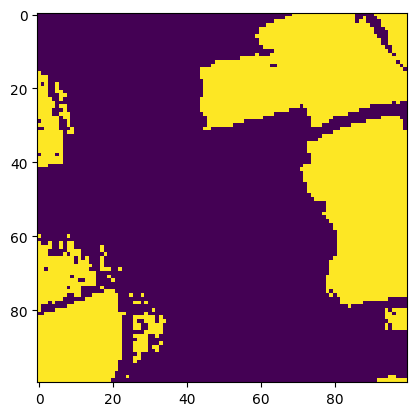

In [152]:
import xarray as xr
import matplotlib.pyplot as plt

output = xr.open_dataset('2024_05_24_16_16_00_output_presto.nc')
plt.imshow(output['classification'])

